In [24]:
import os, sys, time, importlib, json, copy
from datetime import datetime
import numpy as np
from cpuinfo import get_cpu_info
from OuterDeployment.HarrisCorner import *
from SensorModule.Sensor import Sensor
from Tools.PlotTools import VisualTool
from Tools.MapLoader import MapLoader
from Tools.Mask import layer_map

In [25]:
vis=VisualTool(show=True, size=(3,3), save=False)

전체 맵데이터 레이아웃 파악

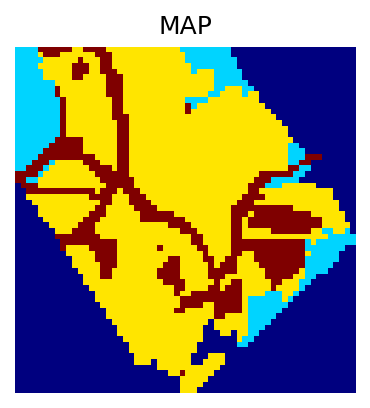

In [26]:
map=MapLoader().load("gangjin.crop1")
vis.showJetMap(map)

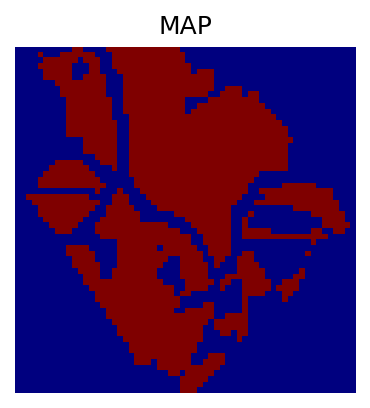

In [27]:
installable_layer = layer_map(map, keep_values=[2])
vis.showJetMap(installable_layer)

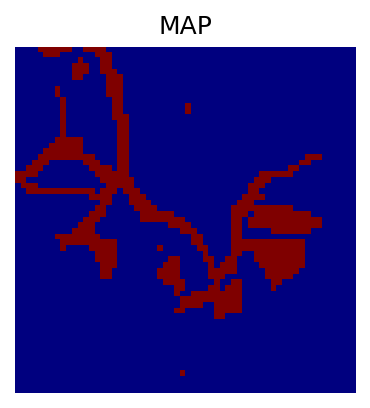

In [28]:
road_layer = layer_map(map, keep_values=[3])
vis.showJetMap(road_layer)

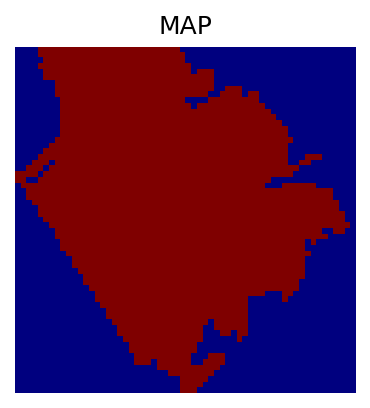

In [29]:
jobsite_layer = layer_map(map, keep_values=[2,3])
vis.showJetMap(jobsite_layer)

In [30]:
COVERAGE = 45

센서가 설치가능한 구역 중에서 최외곽센서 설치 가능 지점 탐색

In [31]:
corner_layer = HarrisCorner(map)
corner_candidate = corner_layer.run(installable_layer, blockSize=3, ksize=3, k=0.1, dilate_size=7)

설치 가능한 지점 위에서만 후보 추출하는 과정(코너 후보 지점들이 정확한 코너지점들 추출이 안되서..)

Outmost corner points: 7


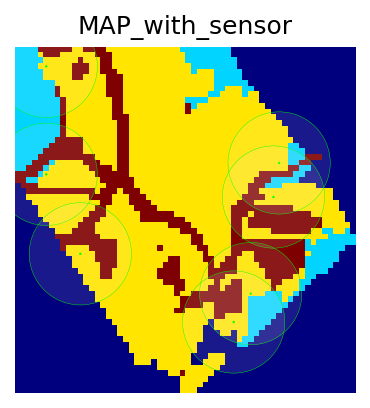

In [32]:
installable = np.asarray(installable_layer).astype(bool)  # True = installable

H, W = installable.shape
corner_candidate = [
    (x, y) for (x, y) in corner_candidate
    if 0 <= x < W and 0 <= y < H and installable[y, x]
]


print("Outmost corner points:", len(corner_candidate))
vis.showJetMap_circle(map, corner_candidate, radius=45)

In [33]:
from InnerDeployment.GeneticAlgorithm.main import SensorGA

In [ ]:
optimized_result = SensorGA(
                installable_map=installable_layer,
                jobsite_map=jobsite_layer,
                coverage=COVERAGE,
                generations=100,
                corner_positions=corner_candidate,
                initial_size=100,
                selection_size=50,
                child_chromo_size=100,
                min_sensors=50,
                max_sensors=100,
            ).run(
                    selection_method="elite",
                    mutation_rate=0.7,
                    early_stop=True,
                    early_stop_coverage=90.0,
                    early_stop_patience=5,
                    return_best_only=True
                )


[Gen:001/100] Fitness : (best=100.0000, avg=98.7707, worst=92.3077) | Coverage(best)=100.00% | Numb of sensors : (min=18, avg=21.0, max=25) | BestSensors=20 (corner=7)
[Profile Gen 001] fitness=40.323s | selection=0.000s | repro=0.391s (crossover=0.225s, mutation=0.165s) | calls: crossover~100, mutation~70.0
               fitness_breakdown: ordering=5.982s | score=34.338s | pop=100 

[Gen:002/100] Fitness : (best=99.5131, avg=93.6130, worst=84.5180) | Coverage(best)=99.51% | Numb of sensors : (min=14, avg=18.2, max=21) | BestSensors=20 (corner=7)
[Profile Gen 002] fitness=3.831s | selection=0.000s | repro=0.325s (crossover=0.152s, mutation=0.173s) | calls: crossover~100, mutation~70.0
               fitness_breakdown: ordering=0.527s | score=3.302s | pop=100 

[Gen:003/100] Fitness : (best=99.8053, avg=89.6353, worst=77.5560) | Coverage(best)=99.81% | Numb of sensors : (min=14, avg=16.6, max=21) | BestSensors=20 (corner=7)
[Profile Gen 003] fitness=2.866s | selection=0.000s | repro=0.

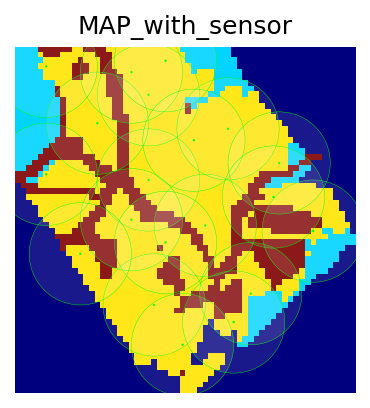

In [35]:
vis.showJetMap_circle(
    map_data=map, 
    sensor_positions=optimized_result+corner_candidate,
    radius=COVERAGE
    )